# Post training quantization of SpeechBrain Wav2Vec2 on GPU


This notebook provides code for post training quantization of the speechbrain/asr-wav2vec2-librispeech model. We compare base model and post training quantizated model on the librispeech dataset.

First, let's install `datasets`,  `transformers` and `librosa`.

In [16]:
# # %%capture
!pip install datasets==1.18.3
!pip install transformers==4.17.0
!pip install jiwer
!pip install librosa

In [17]:
device = 'cuda'

Next, we install `TensorRT` from source to use its tool `pytorch-quantization` for GPU quantization.

In [18]:
! git clone https://github.com/NVIDIA/TensorRT.git

In [19]:
! cd TensorRT/tools/pytorch-quantization && pip install .

In [20]:
! pip install --upgrade tensorrt

## Prepare Data

In [ ]:
from datasets import load_dataset, load_metric

# Dataset is downloaded from https://www.openslr.org/12
data = load_dataset("LibriSpeech")

In [22]:
from parse_data import parse_to_json
import json
import os

parse_to_json("./LibriSpeech/dev-clean")
os.rename('data.json', 'dev-clean.json')
with open('dev-clean.json', 'r') as file:
    dev_clean_data = json.load(file)

parse_to_json("./LibriSpeech/test-clean")
os.rename('data.json', 'test-clean.json')
with open('test-clean.json', 'r') as file:
    test_clean_data = json.load(file)

In [23]:
dev_clean_dict = {}
for key, value in dev_clean_data.items():
    new_key = key.replace('-', '')
    dev_clean_dict[new_key] = value

In [24]:
test_clean_dict = {}
for key, value in test_clean_data.items():
    new_key = key.replace('-', '')
    test_clean_dict[new_key] = value

In [25]:
import soundfile as sf
import resampy

def flac_to_array_with_sampling_rate(file_path, target_sr=16000):
    data, sr = sf.read(file_path, dtype='float32')

    if sr != target_sr:
        data = resampy.resample(data, sr, target_sr)

    return data

In [26]:
import re
chars_to_ignore_regex = '[\,\?\.\!\-\;\:\"]'

def remove_special_characters_dev(batch):
    batch["text"] = re.sub(chars_to_ignore_regex, '', batch["text"]).lower() + " "
    trimmed_string = batch["text"].strip()
    words = trimmed_string.split()
    new_text = ' '.join(words[1:])
    batch["text"] = new_text
    batch["input_values"] = flac_to_array_with_sampling_rate(dev_clean_dict[words[0]]['file_path'])
    return batch

In [27]:
data['validation'] = data['validation'].map(remove_special_characters_dev)

0ex [00:00, ?ex/s]

In [28]:
import re
chars_to_ignore_regex = '[\,\?\.\!\-\;\:\"]'

def remove_special_characters_test(batch):
    batch["text"] = re.sub(chars_to_ignore_regex, '', batch["text"]).lower() + " "
    trimmed_string = batch["text"].strip()
    words = trimmed_string.split()
    new_text = ' '.join(words[1:])
    batch["text"] = new_text
    batch["input_values"] = flac_to_array_with_sampling_rate(test_clean_dict[words[0]]['file_path'])
    return batch

In [29]:
data['test'] = data['test'].map(remove_special_characters_test)

0ex [00:00, ?ex/s]

## Base Model

In [30]:
from speechbrain.pretrained import EncoderASR
import torch

In [ ]:
asr_model = EncoderASR.from_hparams(source="speechbrain/asr-wav2vec2-librispeech", savedir="pretrained_models/asr-wav2vec2-librispeech", run_opts={"device":"cuda"})

In [ ]:
torch.onnx.export(asr_model.mods.encoder.wav2vec2.model,
             args=torch.tensor(data['test'][:1]["input_values"]).cuda(),
             f="asr-wav2vec2-librispeech.onnx",
             export_params=True,
             opset_version=17,
             do_constant_folding=True,
             input_names = ['modelInput'],
             output_names = ['modelOutput'],
             dynamic_axes={'modelInput' : {0 : 'batch_size', 1: 'batch_size'},
             'modelOutput' : {0 : 'batch_size'}}
)

## Post Training Quantization

In [32]:
import pytorch_quantization
from pytorch_quantization import nn as quant_nn
from pytorch_quantization import quant_modules
from pytorch_quantization.tensor_quant import QuantDescriptor
from pytorch_quantization import calib

In [ ]:
model_quantized = EncoderASR.from_hparams(source="speechbrain/asr-wav2vec2-librispeech", savedir="pretrained_models/asr-wav2vec2-librispeech", run_opts={"device":"cuda"})

In [34]:
quant_desc_input = QuantDescriptor(calib_method='max', num_bits=8, fake_quant=True)
quant_nn.QuantConv1d.set_default_quant_desc_input(quant_desc_input)
quant_nn.QuantLinear.set_default_quant_desc_input(quant_desc_input)

In [ ]:
quant_modules.initialize()
model_full_quantized = EncoderASR.from_hparams(source="speechbrain/asr-wav2vec2-librispeech", savedir="pretrained_models/asr-wav2vec2-librispeech", run_opts={"device":"cuda"})

In [36]:
model_full_quantized.mods.encoder.wav2vec2.model.feature_extractor.conv_layers[0].conv._weight_quantizer.enable_calib()
model_full_quantized.mods.encoder.wav2vec2.model.feature_extractor.conv_layers[0].conv._weight_quantizer.disable_quant()

In [37]:
import torch
with torch.no_grad():
    for i in range(2000):
            _ = model_full_quantized.mods.encoder.wav2vec2.model(torch.tensor(data["validation"][i:i+1]["input_values"], device="cuda"))

In [38]:
# Finalize calibration

model_full_quantized.mods.encoder.wav2vec2.model.feature_extractor.conv_layers[0].conv._weight_quantizer.load_calib_amax()
model_full_quantized.mods.encoder.wav2vec2.model.feature_extractor.conv_layers[0].conv._weight_quantizer.disable_calib()
model_full_quantized.mods.encoder.wav2vec2.model.feature_extractor.conv_layers[0].conv._weight_quantizer.enable_quant()

model_full_quantized.cuda()

W1230 14:25:30.079546 140647776845824 tensor_quantizer.py:238] Load calibrated amax, shape=torch.Size([512, 1, 1]).
W1230 14:25:30.080674 140647776845824 tensor_quantizer.py:239] Call .cuda() if running on GPU after loading calibrated amax.
W1230 14:25:30.081472 140647776845824 tensor_quantizer.py:174] Disable MaxCalibrator


EncoderASR(
  (mods): ModuleDict(
    (encoder): LengthsCapableSequential(
      (wav2vec2): HuggingFaceWav2Vec2(
        (model): Wav2Vec2Model(
          (feature_extractor): Wav2Vec2FeatureEncoder(
            (conv_layers): ModuleList(
              (0): Wav2Vec2LayerNormConvLayer(
                (conv): QuantConv1d(
                  1, 512, kernel_size=(10,), stride=(5,)
                  (_input_quantizer): TensorQuantizer(8bit fake per-tensor amax=dynamic calibrator=MaxCalibrator scale=1.0 quant)
                  (_weight_quantizer): TensorQuantizer(8bit fake axis=0 amax=[0.0071, 0.6079](512) calibrator=MaxCalibrator scale=1.0 quant)
                )
                (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
                (activation): GELUActivation()
              )
              (1-4): 4 x Wav2Vec2LayerNormConvLayer(
                (conv): QuantConv1d(
                  512, 512, kernel_size=(3,), stride=(2,)
                  (_input_quantizer

In our final quantized model, we only keep the quantized first conv layer.

In [39]:
model_quantized.mods.encoder.wav2vec2.model.feature_extractor.conv_layers[0].conv = model_full_quantized.mods.encoder.wav2vec2.model.feature_extractor.conv_layers[0].conv

The `pytorch-quantization` only provides `fake` quantization. The quantization is simulatedon the model's weights and activations without actually converting them to lower-bit representations. To get the quantized model, we need to export the model to ONNX. Fake quantization will be broken into a pair of QuantizeLinear/DequantizeLinear ONNX operations. TensorRT will take the generated ONNX graph, and execute it in int8 in the most optimized way to its capability.

In [ ]:
torch.onnx.export(model_quantized.mods.encoder.wav2vec2.model,
             args=torch.tensor(data["test"][:1]["input_values"]).cuda(),
             f="asr-wav2vec2-encoder-quantized-librispeech-8bits.onnx",
             export_params=True,
             opset_version=17,
             do_constant_folding=True,
             input_names = ['modelInput'],
             output_names = ['modelOutput'],
             dynamic_axes={'modelInput' : {0 : 'batch_size', 1: 'batch_size'},
             'modelOutput' : {0 : 'batch_size'}}
)

### Base vs Quantized Model Inference Time

In this section, we compare the inference time of the base model and the quantized model on the test data. Furthermore, we evalute the perfomance of the base and the quantized models using the word error rate (WER) metric.

**Inference**

In [43]:
! pip install onnxruntime-gpu

In [46]:
import onnxruntime as ort
import tensorrt
ort.get_device()

'GPU'

In [ ]:
# Load onnx models
ort_sess_quant = ort.InferenceSession('asr-wav2vec2-encoder-quantized-librispeech-8bits.onnx', providers=['TensorrtExecutionProvider'])
ort_sess_base = ort.InferenceSession('asr-wav2vec2-librispeech.onnx')

In [48]:
import time
import numpy

def compute_inference_time(ort_sess, num_samples):
    model_time = 0
    with torch.no_grad():
        for single_batch in data["test"].select(range(num_samples)):
            input_values = torch.tensor(single_batch["input_values"], device="cpu").unsqueeze(0)
            input_values = input_values.clone().detach().numpy().astype(numpy.float32)
            starttime = time.time()
            ort_sess.run(['modelOutput'], {'modelInput': input_values})
            model_time += time.time() - starttime
    return round(model_time/num_samples, 8)

In [49]:
num_samples = 500

base_model_time = compute_inference_time(ort_sess_base, num_samples)

In [50]:
print(f'Base Model inference time {base_model_time} seconds')

Base Model inference time 0.47431073 seconds


In [65]:
quantized_model_time = compute_inference_time(ort_sess_quant, num_samples)

In [66]:
print(f'Quantized Model inference time {quantized_model_time} seconds')

Quantized Model inference time 0.02014009 seconds


**Inference Time Visualisation of Results**

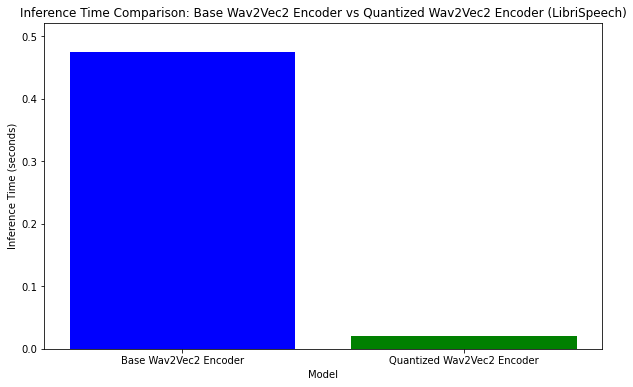

In [67]:
import matplotlib.pyplot as plt

models = ['Base Wav2Vec2 Encoder', 'Quantized Wav2Vec2 Encoder']
inference_times = [base_model_time, quantized_model_time]

plt.figure(figsize=(10, 6))
plt.bar(models, inference_times, color=['blue', 'green'])
plt.xlabel('Model')
plt.ylabel('Inference Time (seconds)')
plt.title('Inference Time Comparison: Base Wav2Vec2 Encoder vs Quantized Wav2Vec2 Encoder (LibriSpeech)')
plt.ylim(0, max(inference_times) * 1.1)
plt.show()

We calculate how many times the quantized model is faster than the base model

In [1]:
speedup_ratio = base_model_time / quantized_model_time
print(f'Quantized wav2vec2 encoder is {round(speedup_ratio)} times faster than base wav2vec2 encoder on LibriSpeech')

Quantized wav2vec2 encoder is 24 times faster than base wav2vec2 encoder on LibriSpeech


**Evaluating WER metric**

In [ ]:
wer_metric = load_metric("wer")

Downloading:   0%|          | 0.00/1.90k [00:00<?, ?B/s]

In [ ]:
def map_model_to_wer_result(model, single_batch):
    input_values = torch.tensor(single_batch["input_values"]).to('cuda')
    with torch.no_grad():
        prediction = model.transcribe_batch(input_values, torch.tensor([1.0]).to('cuda'))
    return wer_metric.compute(predictions=[prediction[0][0].lower()], references=single_batch['text'])

In [ ]:
num_samples = len(data['test'])

In [ ]:
total_wer = 0

for i in range(num_samples):
    total_wer += map_model_to_wer_result(asr_model, data['test'][i:i+1])

base_wer_result = round(total_wer / num_samples, 8)

/home/kmb85/.local/lib/python3.10/site-packages/speechbrain/dataio/encoder.py:722: UserWarning: CTCTextEncoder.expect_len was never called: assuming category count of 31 to be correct! Sanity check your encoder using `.expect_len`. Ensure that downstream code also uses the correct size. If you are sure this does not apply to you, use `.ignore_len`.
  warnings.warn(


In [ ]:
print(f'Base Model WER: {base_wer_result}')

Base Model WER: 0.0229328


In [ ]:
total_wer_quant = 0

for i in range(num_samples):
    total_wer_quant += map_model_to_wer_result(model_quantized, data['test'][i:i+1])

quant_wer_result = round(total_wer_quant / num_samples, 4)

In [ ]:
print(f'Quantized Model WER: {quant_wer_result}')

Quantized Model WER: 0.0238


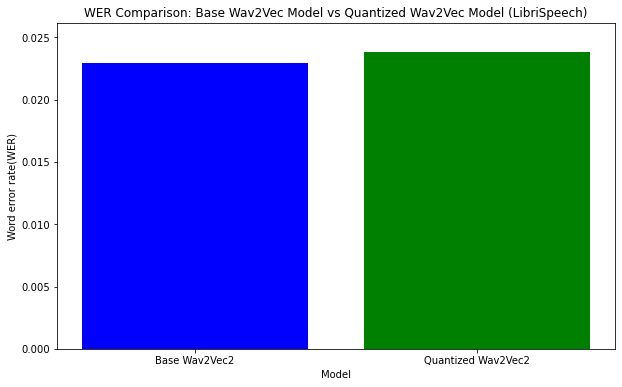

In [ ]:
import matplotlib.pyplot as plt

models = ['Base Wav2Vec2', 'Quantized Wav2Vec2']
inference_times = [base_wer_result, quant_wer_result]

plt.figure(figsize=(10, 6))
plt.bar(models, inference_times, color=['blue', 'green'])
plt.xlabel('Model')
plt.ylabel('Word error rate(WER)')
plt.title('WER Comparison: Base Wav2Vec Model vs Quantized Wav2Vec Model (LibriSpeech)')
plt.ylim(0, max(inference_times) * 1.1)
plt.show()

In [ ]:
percentage_diff = ((quant_wer_result - base_wer_result) / quant_wer_result) * 100
print(f'WER difference between the quantized model and the base model is {round(percentage_diff, 2)}%')

WER difference between the quantized model and the base model is 3.64%
